# **Notebook: Double Descent**

Natalia Campiglia - 349251

Maria Jose Carbajal - 241319

---

Esta notebook investiga el fenómeno **double descent** que ocurre en las Redes Neuronales.

En el aprendizaje automático, a menudo esperamos que a medida que la capacidad de un modelo (por ejemplo, el número de parámetros) aumenta, el error de entrenamiento disminuya y el error de prueba eventualmente aumente después de cierto punto (el clásico "overfitting"). Sin embargo, el fenómeno de Double Descent desafía esta intuición al mostrar que, en ciertos escenarios, a medida que la capacidad del modelo continúa aumentando más allá del punto de overfitting, el error de prueba puede volver a disminuir.

En esta notebook:

- Utilizamos el dataset MNIST-1D que se puede encontrar en https://github.com/greydanus/mnist1d.
- Entrenamos redes con diferentes capacidades (variando el número de unidades ocultas)
- Analizamos cómo el ruido en las etiquetas del conjunto de entrenamiento influye en la forma de la curva Double Descent.

## Dataset

In [86]:
!pip install torchinfo

In [87]:
# Instalar el dataset MNIST 1D
!pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /private/var/folders/s2/p5yczv2s3gv32c5qs90gpnh00000gn/T/pip-req-build-8mhzlo9r
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /private/var/folders/s2/p5yczv2s3gv32c5qs90gpnh00000gn/T/pip-req-build-8mhzlo9r
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [88]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d
from torchinfo import summary
import torch.optim as optim

from sklearn.model_selection import train_test_split

import random
random.seed(0)

from utils import (
    train,
    plot_training,
)


In [89]:
# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

Usando mps


In [90]:
LR = 0.005
CRITERION = nn.CrossEntropyLoss().to(DEVICE)
BATCH_SIZE = 128
EPOCHS = 1600
# [2, 10, 26, 45, 48, 50, 55, 70, 120, 200, 250, 300]
# [2, 10, 26, 45, 48, 50, 55, 70, 120, 200, 250].

HIDDEN_SIZES = [0, 16, 26, 45, 48, 50, 52, 55,70, 120, 200, 250, 300]

In [91]:
def get_noisy_mnist1d_dataset(noise_rate=0.0):
    """
    Generates the MNIST-1D dataset with a specified amount of noise in the training labels.

    Args:
        noise_rate (float): The proportion of training labels to flip randomly.

    Returns:
        dict: A dictionary containing the noisy dataset.
    """
    args = mnist1d.data.get_dataset_args()
    args.num_samples = 8000
    args.train_split = 0.5
    args.corr_noise_scale = 0.25
    args.iid_noise_scale = 2e-2
    data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl',
                                    download=False, regenerate=True)

    # Add noise to training labels
    for c_y in range(len(data['y'])):
        random_number = random.random()
        if random_number < noise_rate:
            random_int = int(random.random() * 10)
            data['y'][c_y] = random_int

    return data

In [92]:
data = get_noisy_mnist1d_dataset(noise_rate=0.0)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Dimensionality of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 4000
Dimensionality of each example: 40


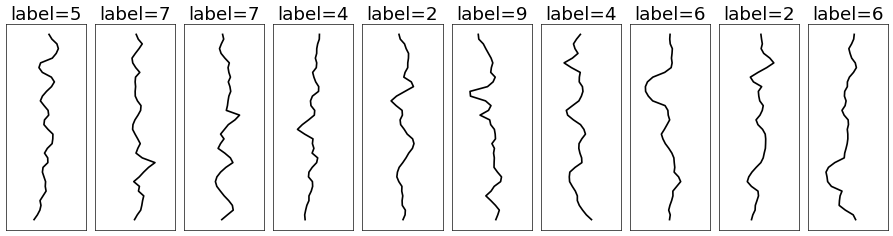

In [93]:
def plot_signals(xs, t, labels=None, ratio=2.6, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig


# Sample 10 random examples from test
num_test_examples = len(data['y_test'])
sample_indices_test = random.sample(range(num_test_examples), 10)

xs = data['x_test'][sample_indices_test]
labels = data['y_test'][sample_indices_test]
t = data['t']
_ = plot_signals(xs, t, labels=labels, ratio=2.7, zoom=6)

Ahora definiremos la función `get_model`, encargada de construir nuestra red neuronal.

**Tarea:**
Completa la función `get_model` con las siguientes especificaciones:

1. Define las dimensiones:
    * Entrada (D_i): debe coincidir con la dimensionalidad de cada muestra del dataset MNIST-1D.
    * Oculta (n_hidden): se recibe como argumento de la función.
    * Salida (D_o): igual al número de clases.

2. Crea una arquitectura secuencial con las siguientes capas:
    - Capa lineal de entrada.
    - Activación ReLU.
    - Capa lineal oculta.
    - Activación ReLU.
    - Capa lineal de salida.

3. Devuelve el modelo resultante.

In [94]:
print(data['x'].shape) #(N, D)
print(f"Número de ejemplos de entrenamiento: {data['x'].shape[0]}")
print(f"Dimensionalidad de cada ejemplo: {data['x'].shape[-1]}")
INPUT_DIM = data['x'].shape[-1]
OUTPUT_DIM = len(np.unique(data['y']))
print(f"Número de clases: {OUTPUT_DIM}")

(4000, 40)
Número de ejemplos de entrenamiento: 4000
Dimensionalidad de cada ejemplo: 40
Número de clases: 10


In [95]:
def get_model(n_hidden):
  D_i = INPUT_DIM    # Input dimensions
  D_k = n_hidden   # Hidden dimensions
  D_o = OUTPUT_DIM    # Output dimensions

  # Manejar el caso especial cuando n_hidden = 0
  # En este caso, creamos un modelo sin capas ocultas (directo de entrada a salida)
  if n_hidden == 0:
    model = nn.Sequential(
      nn.Linear(D_i, D_o) # capa lineal directa de entrada a salida
    )
  else:
    # Completar
    model = nn.Sequential(
      nn.Linear(D_i, D_k), # capa lineal de entrada
      nn.ReLU(), # activación ReLU
      nn.Linear(D_k, D_k), # capa lineal oculta
      nn.ReLU(), # activación ReLU
      nn.Linear(D_k, D_o) # capa lineal de salida
    )

  # Return the model
  return model;

In [96]:
model = get_model(n_hidden=64)  # por ejemplo
summary(model, input_size=(BATCH_SIZE,INPUT_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128, 10]                 --
├─Linear: 1-1                            [128, 64]                 2,624
├─ReLU: 1-2                              [128, 64]                 --
├─Linear: 1-3                            [128, 64]                 4,160
├─ReLU: 1-4                              [128, 64]                 --
├─Linear: 1-5                            [128, 10]                 650
Total params: 7,434
Trainable params: 7,434
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.95
Input size (MB): 0.02
Forward/backward pass size (MB): 0.14
Params size (MB): 0.03
Estimated Total Size (MB): 0.19

## Entrenamiento y visualización de la curva *Double Descent*

En esta sección vamos a explorar cómo varían el **error de entrenamiento** y el **error de prueba** al aumentar la capacidad de una red neuronal.

**Tu tarea:**

1. Entrena redes neuronales con distintos números de unidades ocultas (`n_hidden`) durante **1000 épocas**, usando los siguientes tamaños de capa oculta:  
   `[2, 10, 26, 45, 48, 50, 55, 70, 120, 200, 250]`.  
2. Registra los errores finales de entrenamiento y prueba para cada modelo.  
3. Grafica los errores en función del número de unidades ocultas para visualizar la **curva de Double Descent**.  
4. Añade una línea vertical que marque el **interpolation threshold**, que se puede representar como el punto en que el número de parámetros del modelo se aproxima al número de ejemplos de entrenamiento. El pico del error de prueba suele aparecer cerca de esta región.

> 💡 **Nota:** la ejecución del código puede tomar un tiempo considerable, ¡así que quizás sea un buen momento para tomar un descanso!


In [97]:
def get_dataloaders(data):
    # Dividimos train/val
    X_train, X_val, y_train, y_val = train_test_split(
        data['x'], data['y'], test_size=0.2, random_state=42
    )

    # Convertimos a tensores
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # Creamos datasets y dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader


## Helpers para contar parámetros y hallar el threshold

In [98]:
# params(H) = (Di*H + H) + (H*H + H) + (H*Do + Do)
        #   = H^2 + H*(Di + Do + 2) + Do

def params_for_hidden(H, D_i=INPUT_DIM, D_o=OUTPUT_DIM):
    return H*H + H*(D_i + D_o + 2) + D_o

def count_params_torch(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

def find_threshold_hidden(n_train, D_i=INPUT_DIM, D_o=OUTPUT_DIM):
    """
    Devuelve el H (real) donde params_for_hidden(H) ~= n_train
    Resolviendo el cuadrático: H^2 + B*H + C = 0 con:
      B = (D_i + D_o + 2)
      C = (D_o - n_train)
    Tomamos la raíz positiva.
    """
    import math
    B = (D_i + D_o + 2)
    C = (D_o - n_train)
    disc = B*B - 4*1*C
    H_pos = (-B + math.sqrt(disc)) / 2.0
    return H_pos

def closest_hidden_to_threshold(hidden_sizes, n_train, D_i=INPUT_DIM, D_o=OUTPUT_DIM):
    H_star = find_threshold_hidden(n_train, D_i, D_o)
    # Elegimos el H de la lista más cercano a H* para marcar en la gráfica
    return min(hidden_sizes, key=lambda h: abs(h - H_star)), H_star




In [99]:
def train_model(n_hidden, train_loader, val_loader):
    base_model = get_model(n_hidden).to(DEVICE)
    optimizer = optim.Adam(base_model.parameters(), lr=LR)

    epoch_train_errors, epoch_val_errors = train(
        base_model,
        optimizer,
        CRITERION,
        train_loader,
        val_loader,
        DEVICE,
        do_early_stopping=False,
        patience=20,
        epochs=EPOCHS,
        log_every=500,
    )

    plot_training(epoch_train_errors, epoch_val_errors, n_hidden)

    n_params = count_params_torch(base_model)  # o params_for_hidden(n_hidden)

    return epoch_train_errors[-1], epoch_val_errors[-1], n_params

In [100]:
train_loader, val_loader = get_dataloaders(data)


Entrenando modelo con 0 unidades ocultas
Epoch: 500/1600 | Train Loss: 1.59431 | Val Loss: 1.65605
Epoch: 1000/1600 | Train Loss: 1.59676 | Val Loss: 1.65565
Epoch: 1500/1600 | Train Loss: 1.59735 | Val Loss: 1.65589


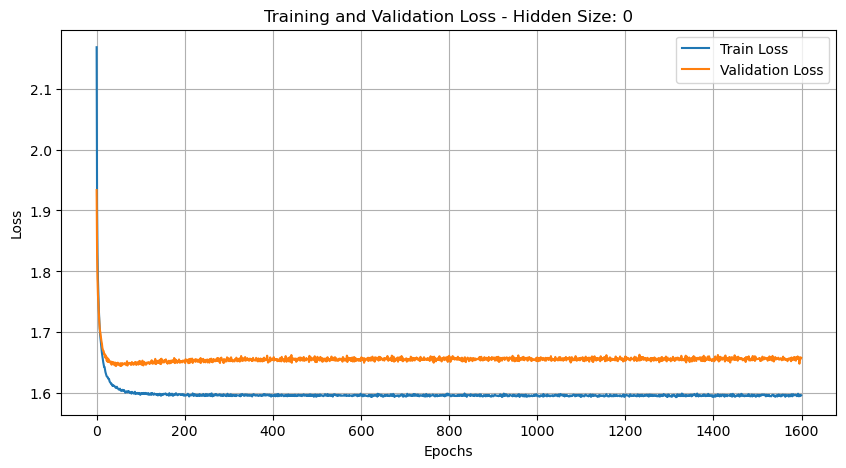


Entrenando modelo con 16 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.87908 | Val Loss: 2.03574
Epoch: 1000/1600 | Train Loss: 0.82939 | Val Loss: 2.49120
Epoch: 1500/1600 | Train Loss: 0.79591 | Val Loss: 2.76869


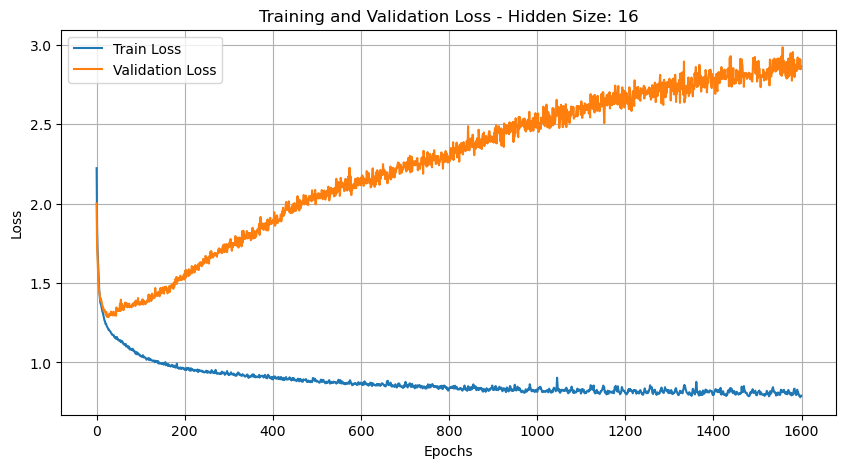


Entrenando modelo con 26 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.42063 | Val Loss: 3.58059
Epoch: 1000/1600 | Train Loss: 0.32490 | Val Loss: 5.85137
Epoch: 1500/1600 | Train Loss: 0.20814 | Val Loss: 8.18232


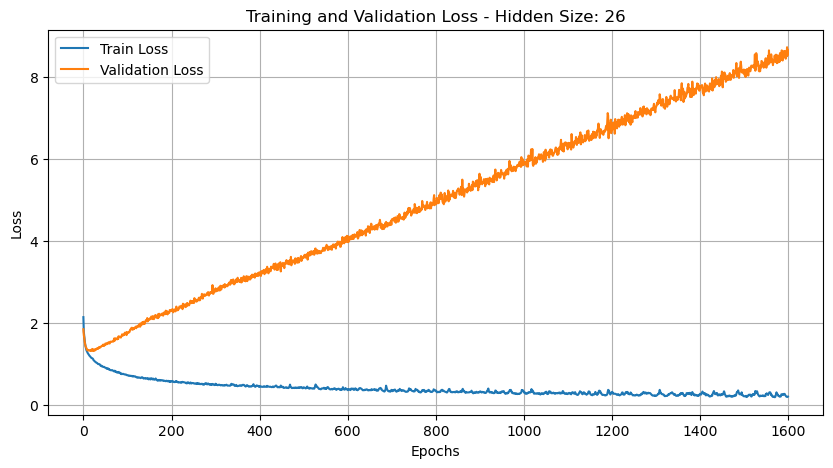


Entrenando modelo con 45 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00005 | Val Loss: 8.94463
Epoch: 1000/1600 | Train Loss: 0.00000 | Val Loss: 14.74815
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 13.51175


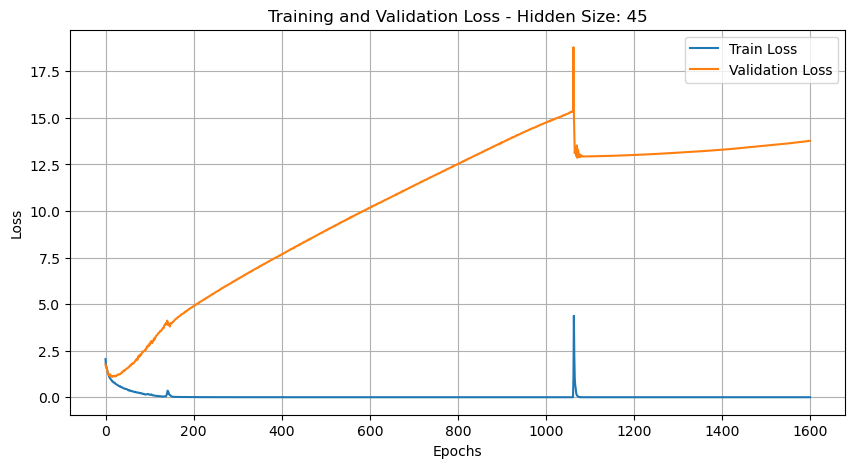


Entrenando modelo con 48 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00003 | Val Loss: 7.94454
Epoch: 1000/1600 | Train Loss: 0.00000 | Val Loss: 13.01068
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 11.70117


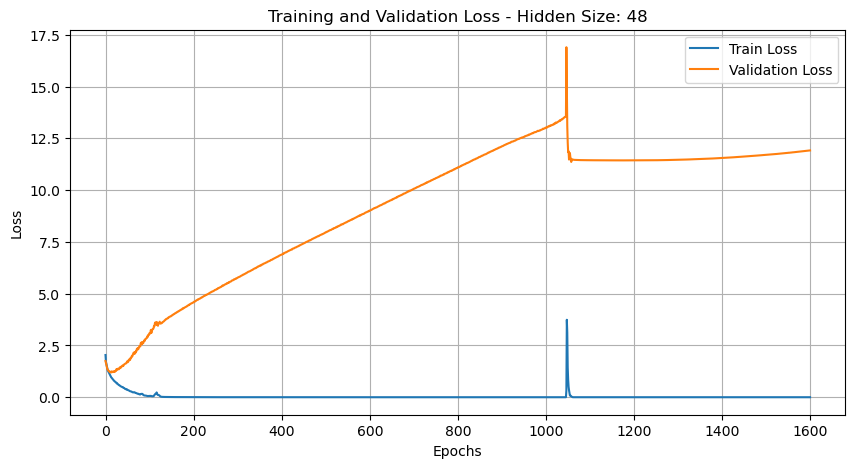


Entrenando modelo con 50 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00003 | Val Loss: 6.79031
Epoch: 1000/1600 | Train Loss: 0.00000 | Val Loss: 11.00312
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 10.09706


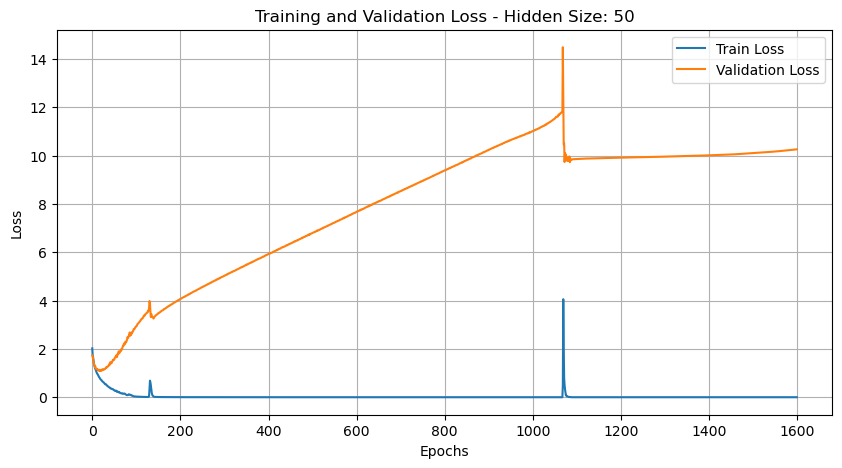


Entrenando modelo con 52 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00001 | Val Loss: 7.30443
Epoch: 1000/1600 | Train Loss: 0.00000 | Val Loss: 11.63350
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 9.99915


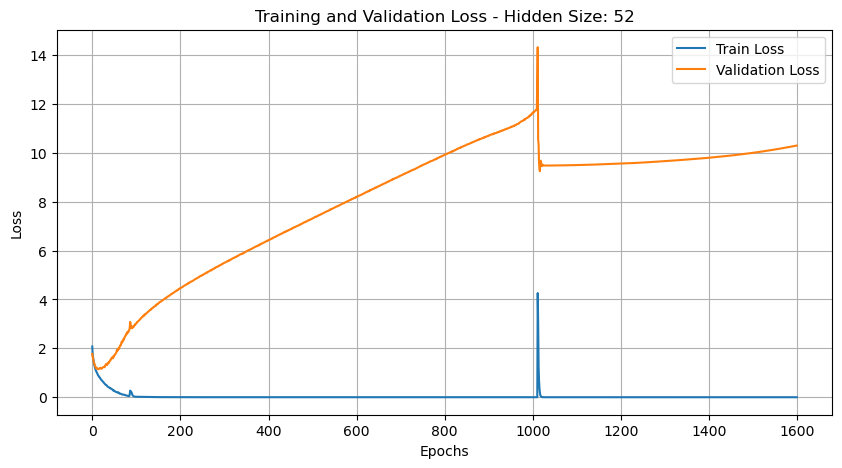


Entrenando modelo con 55 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00001 | Val Loss: 7.73532
Epoch: 1000/1600 | Train Loss: 0.00019 | Val Loss: 9.46144
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 10.27642


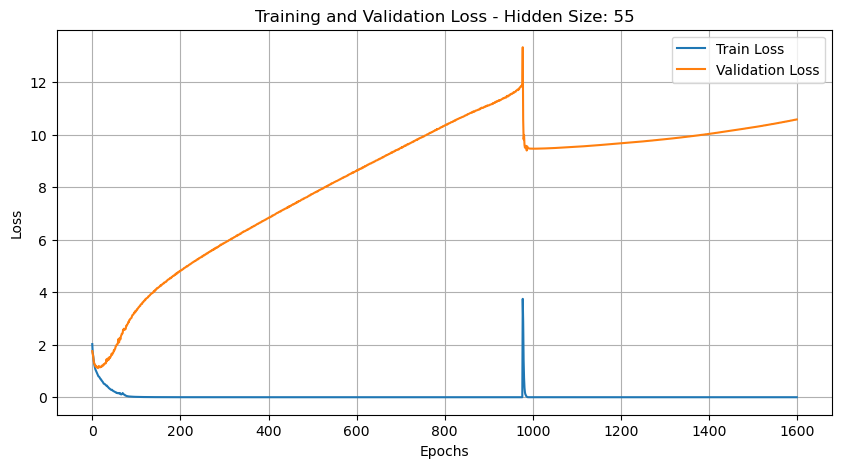


Entrenando modelo con 70 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00000 | Val Loss: 6.78342
Epoch: 1000/1600 | Train Loss: 0.00012 | Val Loss: 7.37763
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 8.48507


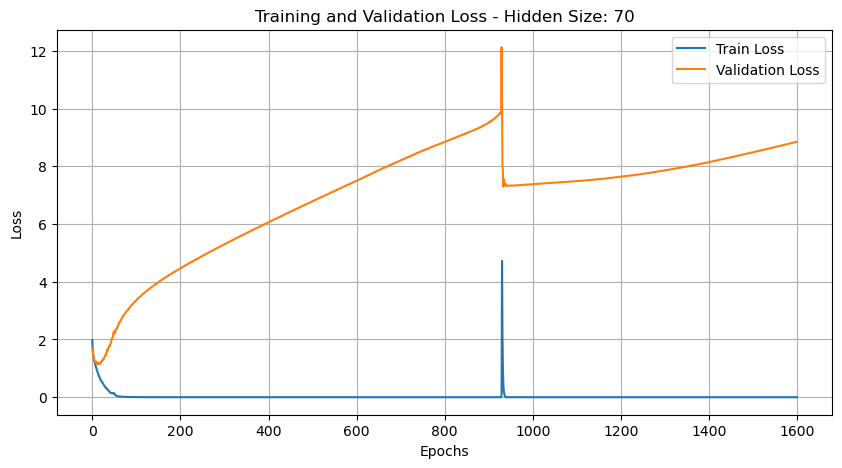


Entrenando modelo con 120 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00000 | Val Loss: 4.70576
Epoch: 1000/1600 | Train Loss: 0.00025 | Val Loss: 3.81355
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 5.54266


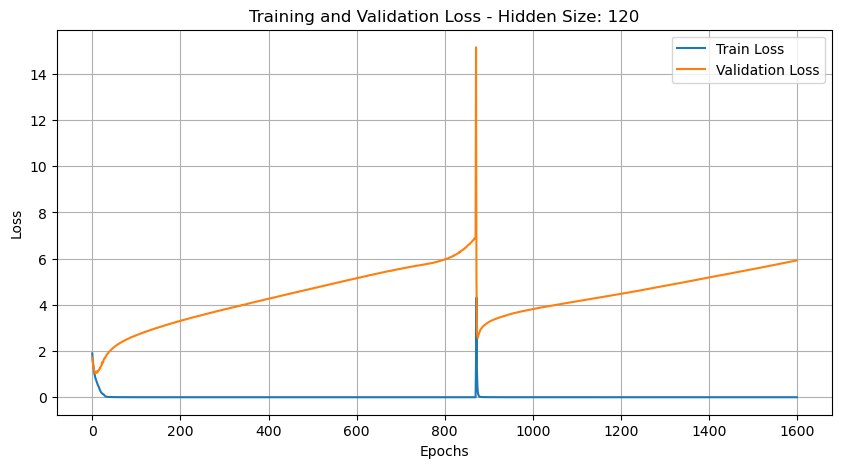


Entrenando modelo con 200 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00000 | Val Loss: 3.65209
Epoch: 1000/1600 | Train Loss: 0.00016 | Val Loss: 2.82029
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 4.24742


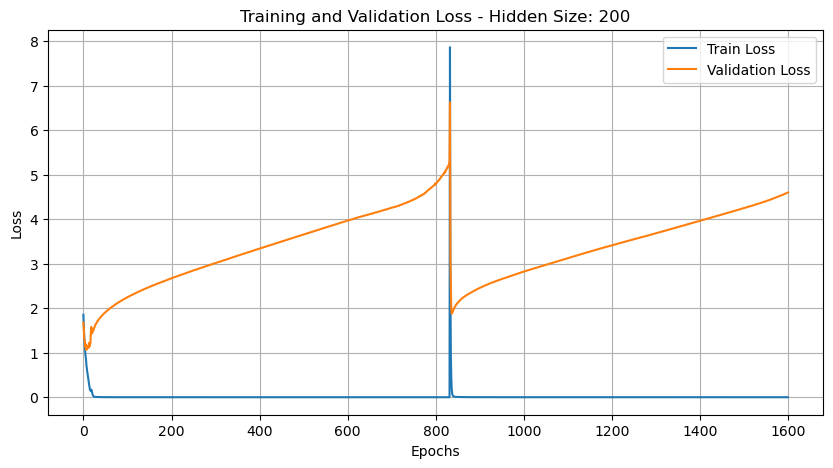


Entrenando modelo con 250 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00000 | Val Loss: 3.74797
Epoch: 1000/1600 | Train Loss: 0.00011 | Val Loss: 2.96990
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 4.51179


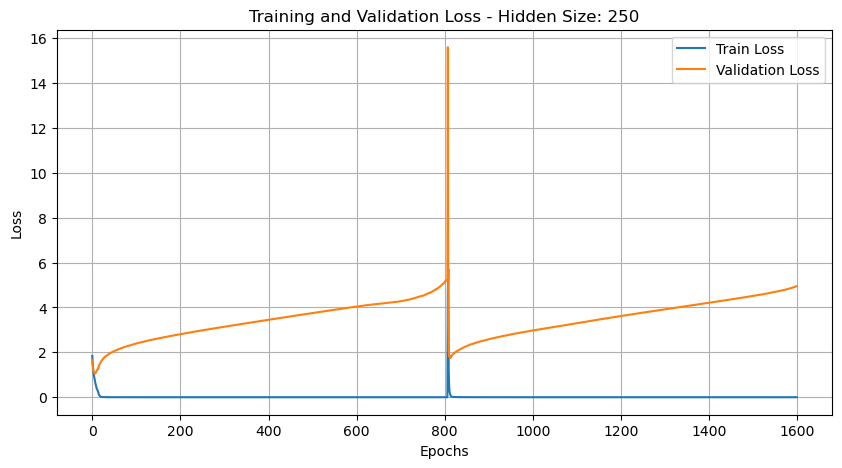


Entrenando modelo con 300 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00000 | Val Loss: 3.10798
Epoch: 1000/1600 | Train Loss: 0.00011 | Val Loss: 2.62497
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 3.94456


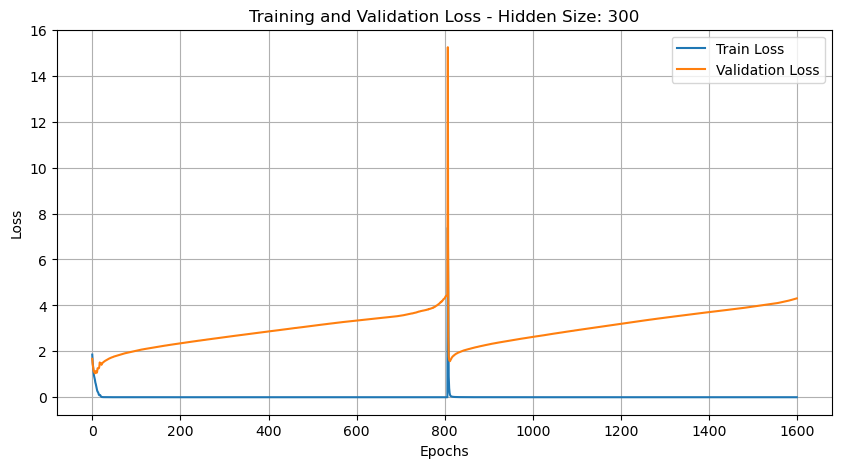

In [ ]:
training_errors = []
validation_errors = []
param_counts = []
for n_hidden in HIDDEN_SIZES:
    print(f"\nEntrenando modelo con {n_hidden} unidades ocultas")
    train_error, val_error, n_params = train_model(n_hidden, train_loader, val_loader)
    training_errors.append(train_error)
    validation_errors.append(val_error)
    param_counts.append(n_params)

# n_train es el tamaño REAL del split de entrenamiento (p.ej., 80% de 4000 = 3200)
n_train = len(train_loader.dataset)

In [102]:
print(f"Entrenamiento finalizado. Errores finales:")
print(f"Entrenamiento: {training_errors:}")
print(f"Validación: {validation_errors}")


Entrenamiento finalizado. Errores finales:
Entrenamiento: [1.5965630722045898, 0.790665545463562, 0.19886511862277984, 1.0749660896181013e-06, 8.737272423786635e-07, 7.208420106508129e-07, 5.512304528565437e-07, 3.905590688191296e-07, 2.1513541867079767e-07, 6.32181655646491e-08, 2.8461214185426796e-08, 1.6465781413899096e-08, 1.6987322055683763e-08]
Validación: [1.6581782954079765, 2.866450343813215, 8.66202633721488, 13.77272401537214, 11.914940697806221, 10.257908139910016, 10.299498081207275, 10.573912824903216, 8.849835395812988, 5.92086444582258, 4.598540919167655, 4.947708947317941, 4.305645397731236]


In [103]:
def plot_double_descent2(training_errors, validation_errors, title="Curva Double Descent - MNIST-1D (sin ruido)", hidden_sizes=HIDDEN_SIZES):
    plt.figure(figsize=(15,5))
    plt.plot(hidden_sizes, training_errors, 'o-', label='Train Error')
    plt.plot(hidden_sizes, validation_errors, 'o-', label='Validation Error')

    plt.xticks(hidden_sizes)
    plt.xlabel('Número de unidades ocultas (capacidad del modelo)')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [104]:
def plot_double_descent(training_errors, validation_errors,
                        title="Curva Double Descent - MNIST-1D (sin ruido)",
                        hidden_sizes=HIDDEN_SIZES, D_i=INPUT_DIM, D_o=OUTPUT_DIM,
                        n_train=None):

    plt.figure(figsize=(15,5))
    plt.plot(hidden_sizes, training_errors, 'o-', label='Train Error')
    plt.plot(hidden_sizes, validation_errors, 'o-', label='Validation Error')

    plt.xticks(hidden_sizes)
    plt.xlabel('Número de unidades ocultas (capacidad del modelo)')
    plt.ylabel('Error')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Dibujar interpolation threshold si se provee n_train
    if n_train is not None:
        # H* teórico (real) y H de la lista más cercano
        H_closest, H_star = closest_hidden_to_threshold(hidden_sizes, n_train, D_i, D_o)
        params_at_H_closest = params_for_hidden(H_closest, D_i, D_o)

        # Línea vertical en el H de la lista más cercano (para que caiga sobre un tick)
        plt.axvline(x=H_closest, linestyle='--', linewidth=1.5, color='r',
                    label=f'Interpolation threshold ~ H*={H_star:.1f}\n'
                          f'(marcado en H={H_closest}, params≈{params_at_H_closest}, n_train={n_train})')
    plt.legend()
    plt.show()


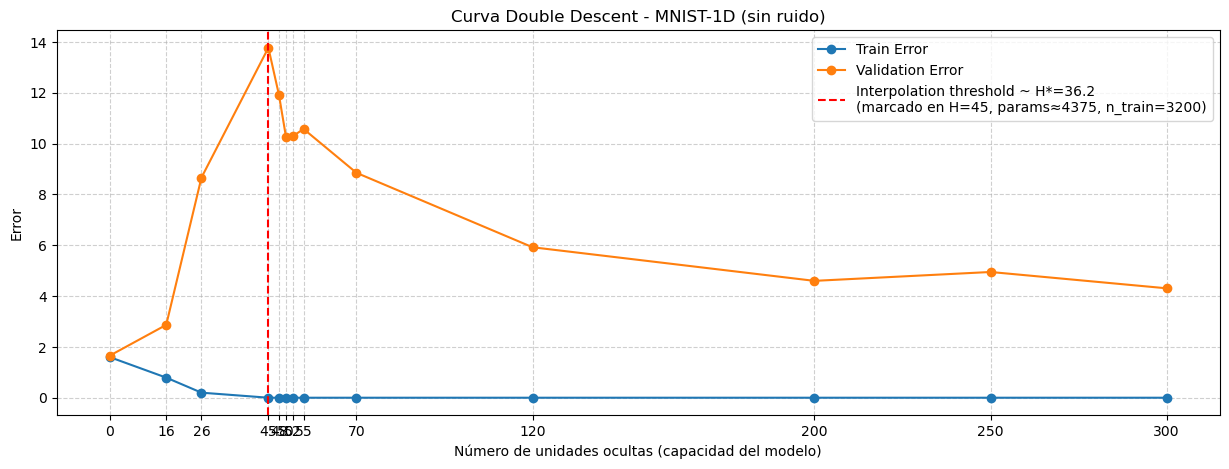

In [105]:
plot_double_descent(training_errors, validation_errors, n_train=n_train)


## Explorando el *Double Descent* con etiquetas ruidosas

En esta sección repetiremos el experimento anterior, pero introduciendo **ruido en las etiquetas** del conjunto de entrenamiento para analizar cómo afecta al fenómeno *Double Descent*.

Entrenaremos nuevamente el modelo con los mismos tamaños de capa oculta:  
`[2, 10, 26, 45, 48, 50, 55, 70, 120, 200, 250]`,  
pero esta vez usaremos datasets en los que un porcentaje de las etiquetas ha sido aleatorizado. Realizaremos el experimento con dos niveles de ruido: **10 %** y **30 %**.

Después de entrenar los modelos para cada nivel de ruido, graficaremos las curvas de error de entrenamiento y prueba, similar a como lo hicimos anteriormente.

**Tu tarea:**

1. Ejecuta la celda siguiente para cargar los datasets con **10 %** y **30 %** de ruido.  
2. Adapta el código de entrenamiento y visualización de la sección anterior para entrenar los modelos con los conjuntos ruidosos y graficar los resultados.


In [106]:
# Carga el dataset MNIST-1D con 10% de ruido en las etiquetas de entrenamiento
data_noisy_10 = get_noisy_mnist1d_dataset(noise_rate=0.10)

# Puedes imprimir información sobre el dataset ruidoso para verificarlo
print("Dataset con 10% de ruido:")
print("Ejemplos en entrenamiento:", len(data_noisy_10['y']))
print("Ejemplos en prueba:", len(data_noisy_10['y_test']))
print("-" * 20)

# Repite el proceso para el 30% de ruido (modificando la tasa de ruido)
data_noisy_30 = get_noisy_mnist1d_dataset(noise_rate=0.30)

print("Dataset con 30% de ruido:")
print("Ejemplos en entrenamiento:", len(data_noisy_30['y']))
print("Ejemplos en prueba:", len(data_noisy_30['y_test']))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Dataset con 10% de ruido:
Ejemplos en entrenamiento: 4000
Ejemplos en prueba: 4000
--------------------
Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Dataset con 30% de ruido:
Ejemplos en entrenamiento: 4000
Ejemplos en prueba: 4000



Entrenando modelo con 0 unidades ocultas
Epoch: 500/1600 | Train Loss: 1.79366 | Val Loss: 1.85851
Epoch: 1000/1600 | Train Loss: 1.79453 | Val Loss: 1.85870
Epoch: 1500/1600 | Train Loss: 1.79325 | Val Loss: 1.85853


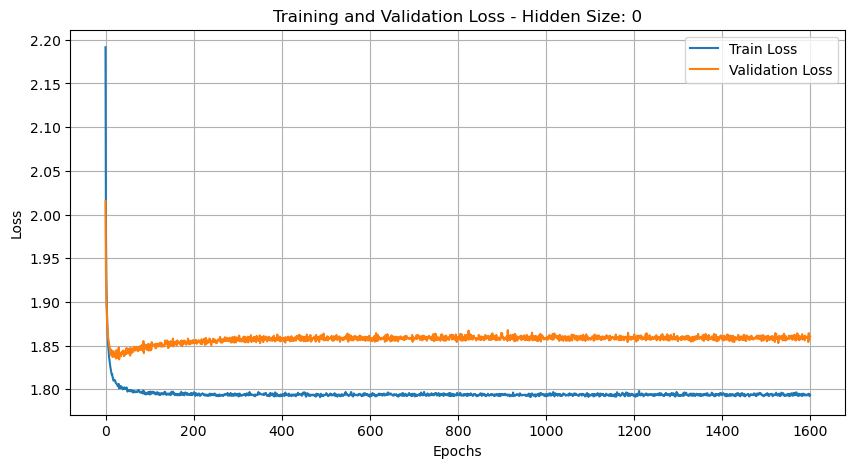


Entrenando modelo con 16 unidades ocultas
Epoch: 500/1600 | Train Loss: 1.12455 | Val Loss: 2.05989
Epoch: 1000/1600 | Train Loss: 1.08864 | Val Loss: 2.17566
Epoch: 1500/1600 | Train Loss: 1.08427 | Val Loss: 2.24133


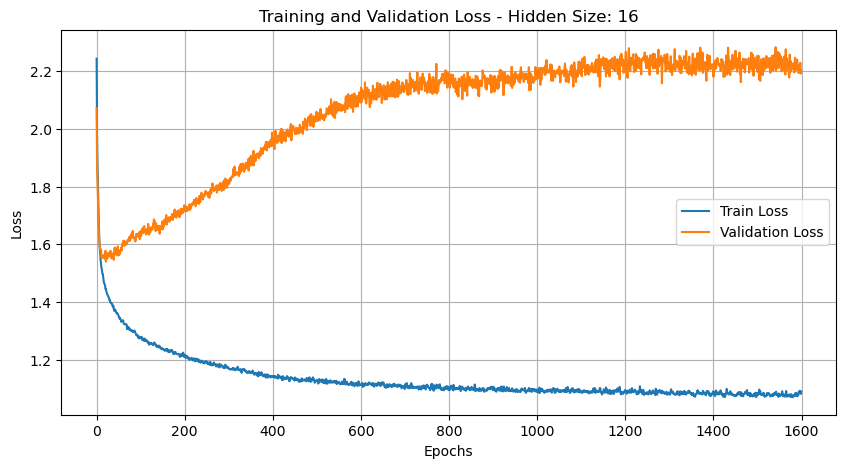


Entrenando modelo con 26 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.59499 | Val Loss: 3.69050
Epoch: 1000/1600 | Train Loss: 0.51284 | Val Loss: 5.25438
Epoch: 1500/1600 | Train Loss: 0.45236 | Val Loss: 6.56999


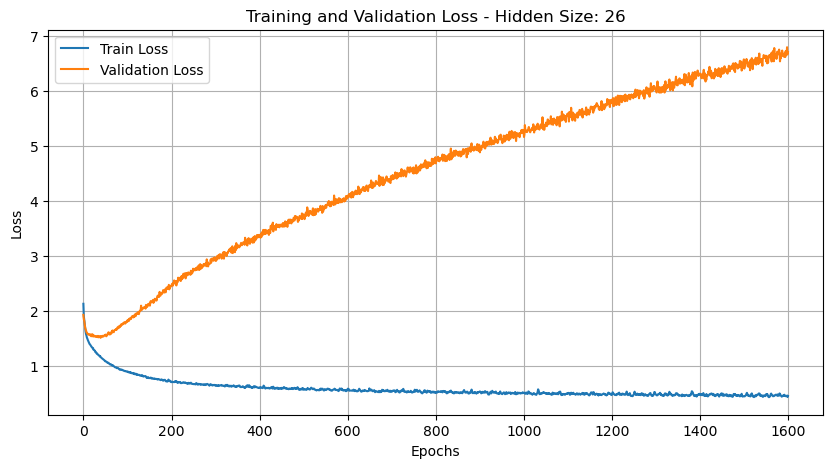


Entrenando modelo con 45 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00134 | Val Loss: 10.01839
Epoch: 1000/1600 | Train Loss: 0.00008 | Val Loss: 13.49495
Epoch: 1500/1600 | Train Loss: 0.00183 | Val Loss: 18.85925


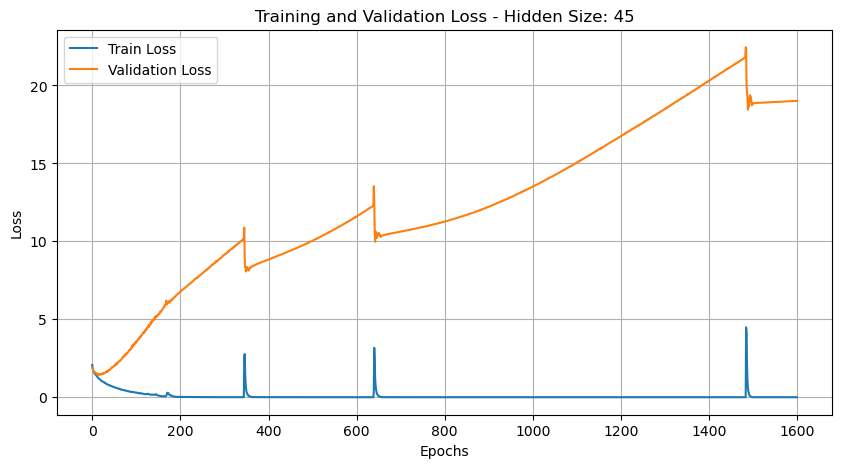


Entrenando modelo con 48 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00452 | Val Loss: 9.50535
Epoch: 1000/1600 | Train Loss: 0.00001 | Val Loss: 14.34317
Epoch: 1500/1600 | Train Loss: 0.00020 | Val Loss: 18.74127


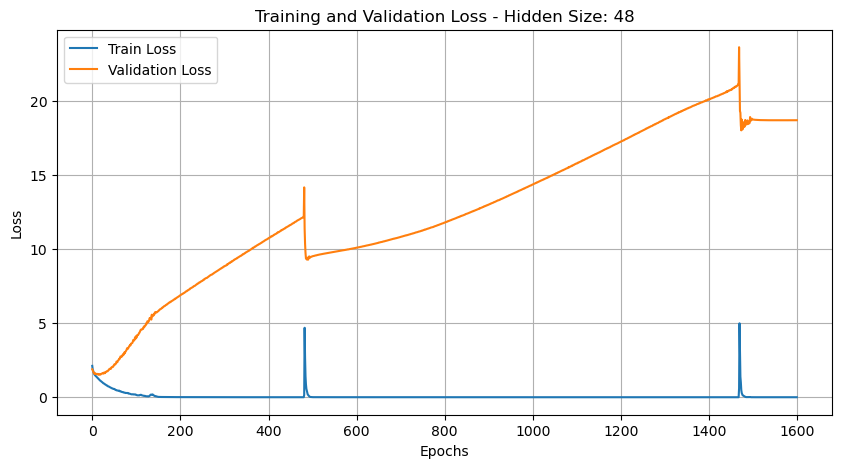


Entrenando modelo con 50 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00004 | Val Loss: 13.11156
Epoch: 1000/1600 | Train Loss: 0.00003 | Val Loss: 14.15198
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 19.45180


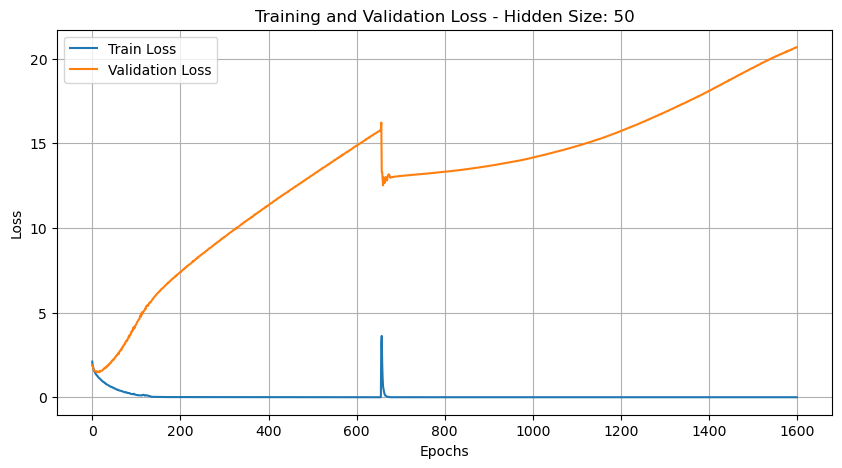


Entrenando modelo con 52 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00016 | Val Loss: 10.48638
Epoch: 1000/1600 | Train Loss: 0.00000 | Val Loss: 18.08754
Epoch: 1500/1600 | Train Loss: 0.00001 | Val Loss: 17.16254


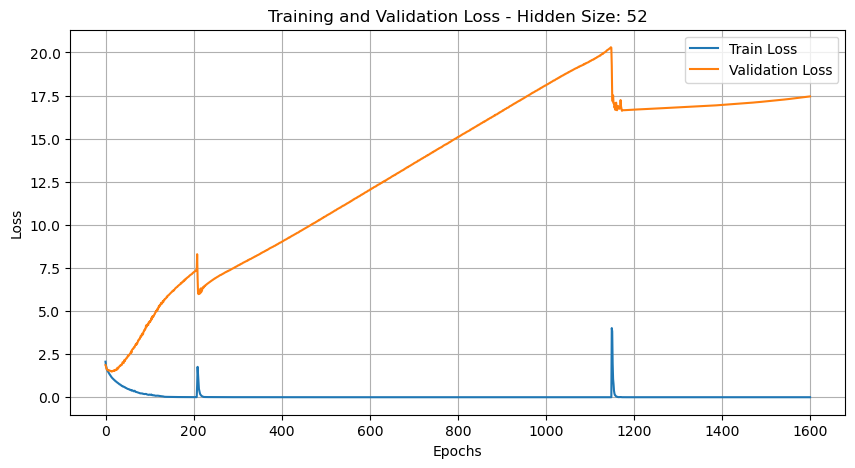


Entrenando modelo con 55 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00002 | Val Loss: 11.55230
Epoch: 1000/1600 | Train Loss: 0.00000 | Val Loss: 18.64620
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 16.51105


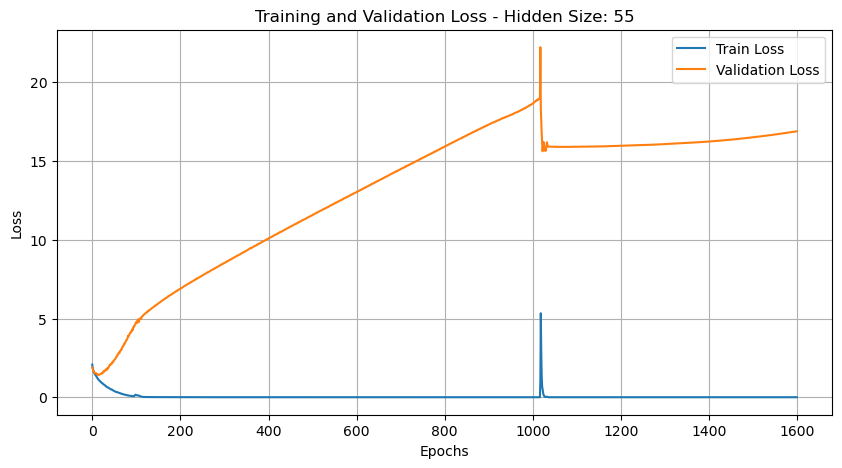


Entrenando modelo con 70 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00001 | Val Loss: 10.20126
Epoch: 1000/1600 | Train Loss: 0.00018 | Val Loss: 11.48305
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 12.90309


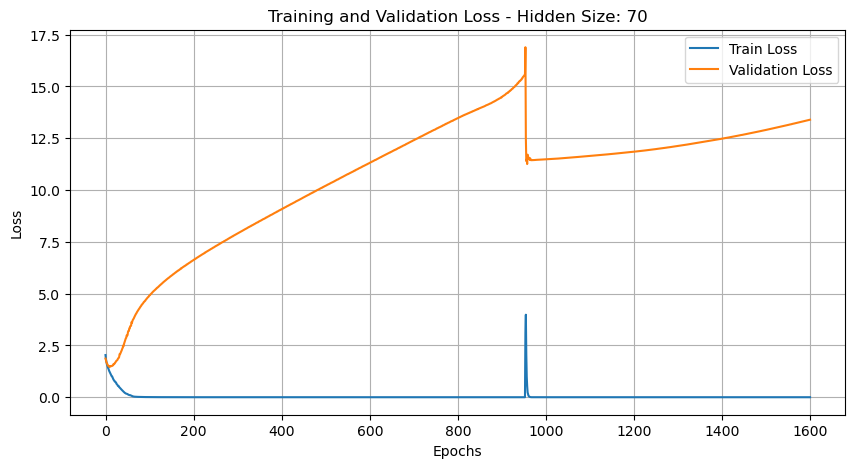


Entrenando modelo con 120 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00000 | Val Loss: 7.09977
Epoch: 1000/1600 | Train Loss: 0.00044 | Val Loss: 5.92605
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 8.86531


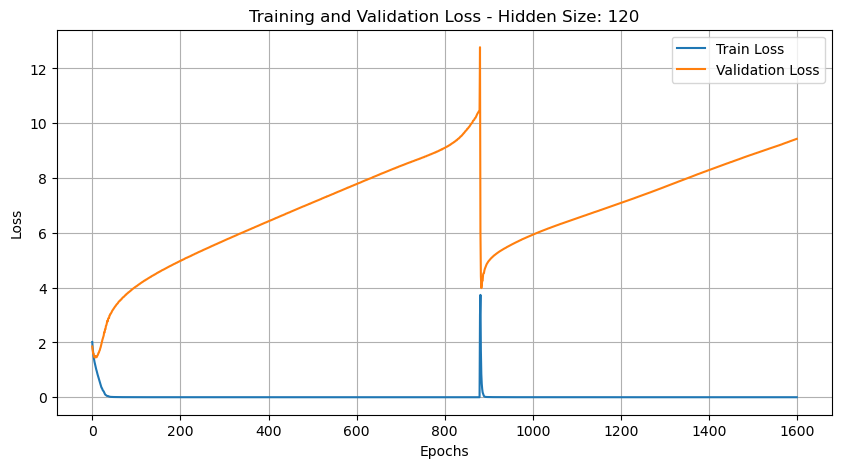


Entrenando modelo con 200 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00000 | Val Loss: 6.12815
Epoch: 1000/1600 | Train Loss: 0.00018 | Val Loss: 5.28611
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 8.24282


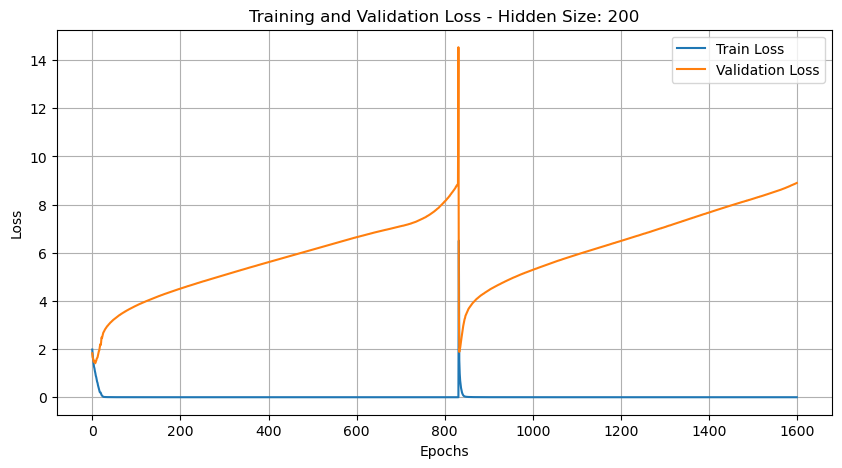


Entrenando modelo con 250 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00000 | Val Loss: 6.03280
Epoch: 1000/1600 | Train Loss: 0.00018 | Val Loss: 5.29877
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 8.12069


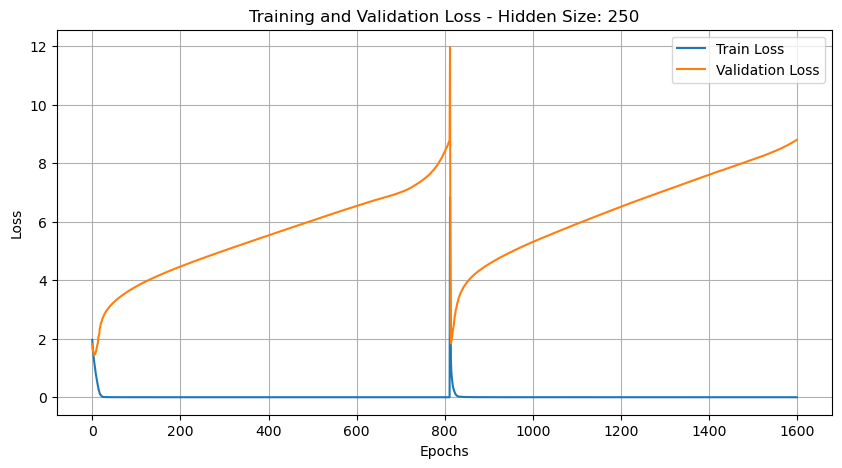


Entrenando modelo con 300 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00000 | Val Loss: 5.40299
Epoch: 1000/1600 | Train Loss: 0.00006 | Val Loss: 5.15994
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 7.86657


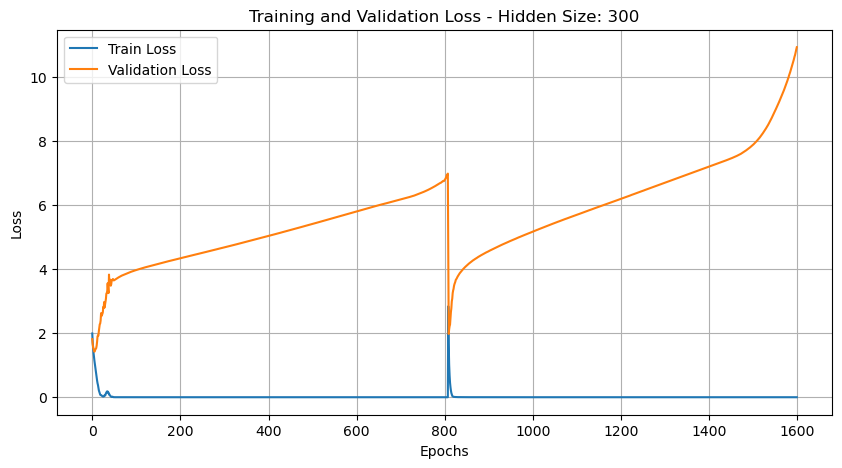

Entrenamiento finalizado. Errores finales:
Entrenamiento: [1.7937558841705323, 1.0889856719970703, 0.4599193823337555, 5.679306894307956e-05, 2.7001116941391955e-05, 2.5071200937532013e-08, 2.743730105976283e-06, 6.892893998156069e-07, 3.175063199023498e-07, 9.682027950930206e-08, 2.8833743499490084e-08, 3.155320491998736e-08, 2.4363395532134292e-08]
Validación: [1.86037996837071, 2.2026898690632413, 6.703474181038993, 19.00793593270438, 18.692143848964147, 20.677852358136857, 17.450563294546946, 16.89031614576067, 13.395685059683663, 9.43124600819179, 8.900828020913261, 8.792380741664342, 10.917852674211774]


In [107]:
train_loader_noisy_10, val_loader_noisy_10 = get_dataloaders(data_noisy_10)
training_errors_noisy_10 = []
validation_errors_noisy_10 = []
param_counts_noisy_10 = []

for n_hidden in HIDDEN_SIZES:
    print(f"\nEntrenando modelo con {n_hidden} unidades ocultas")
    train_error, val_error, n_params = train_model(n_hidden, train_loader_noisy_10, val_loader_noisy_10)
    training_errors_noisy_10.append(train_error)
    validation_errors_noisy_10.append(val_error)
    param_counts_noisy_10.append(n_params)



n_train = len(train_loader_noisy_10.dataset)

print(f"Entrenamiento finalizado. Errores finales:")
print(f"Entrenamiento: {training_errors_noisy_10}")
print(f"Validación: {validation_errors_noisy_10}")


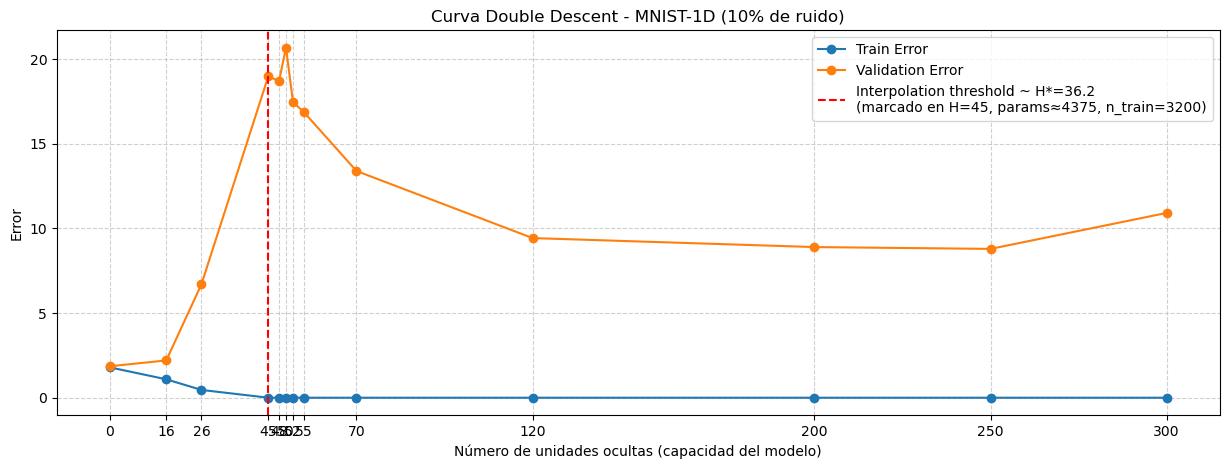

(None,)

In [111]:
plot_double_descent(
    training_errors_noisy_10, validation_errors_noisy_10,
    title="Curva Double Descent - MNIST-1D (10% de ruido)",
    n_train=n_train
),




Entrenando modelo con 0 unidades ocultas
Epoch: 500/1600 | Train Loss: 2.02134 | Val Loss: 2.13422
Epoch: 1000/1600 | Train Loss: 2.02123 | Val Loss: 2.13858
Epoch: 1500/1600 | Train Loss: 2.01968 | Val Loss: 2.13817


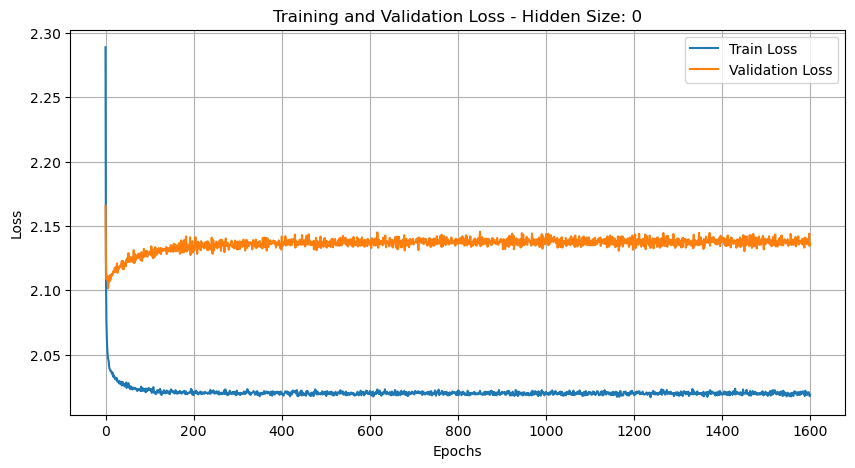


Entrenando modelo con 16 unidades ocultas
Epoch: 500/1600 | Train Loss: 1.45963 | Val Loss: 2.61666
Epoch: 1000/1600 | Train Loss: 1.42625 | Val Loss: 2.87942
Epoch: 1500/1600 | Train Loss: 1.41658 | Val Loss: 2.95470


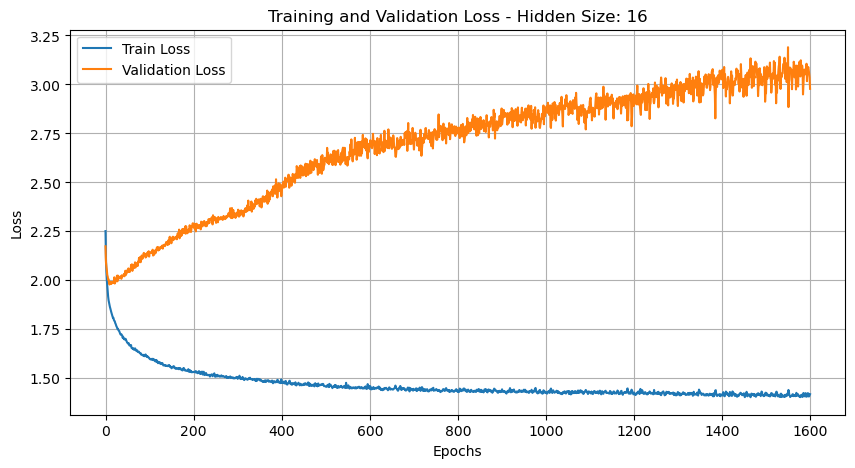


Entrenando modelo con 26 unidades ocultas
Epoch: 500/1600 | Train Loss: 1.04879 | Val Loss: 3.27170
Epoch: 1000/1600 | Train Loss: 1.00143 | Val Loss: 3.91271
Epoch: 1500/1600 | Train Loss: 0.94238 | Val Loss: 4.61072


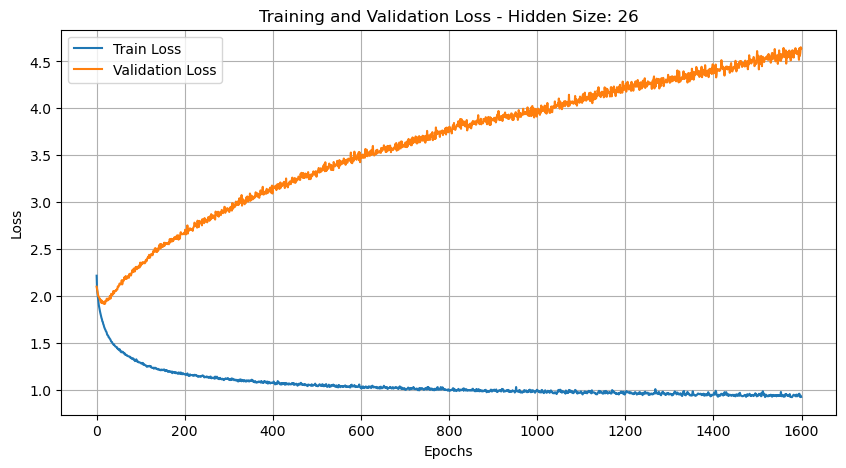


Entrenando modelo con 45 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.01765 | Val Loss: 15.75522
Epoch: 1000/1600 | Train Loss: 0.00457 | Val Loss: 19.02064
Epoch: 1500/1600 | Train Loss: 0.00123 | Val Loss: 22.40399


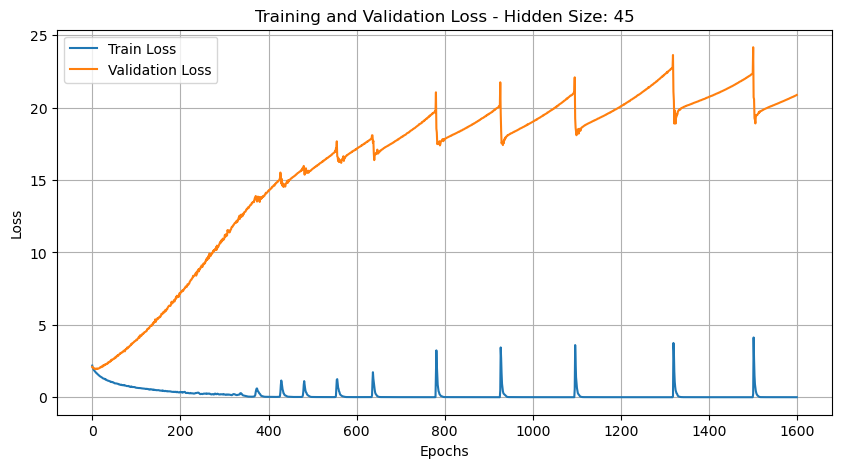


Entrenando modelo con 48 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00494 | Val Loss: 15.11411
Epoch: 1000/1600 | Train Loss: 0.00199 | Val Loss: 18.82892
Epoch: 1500/1600 | Train Loss: 0.00049 | Val Loss: 23.62860


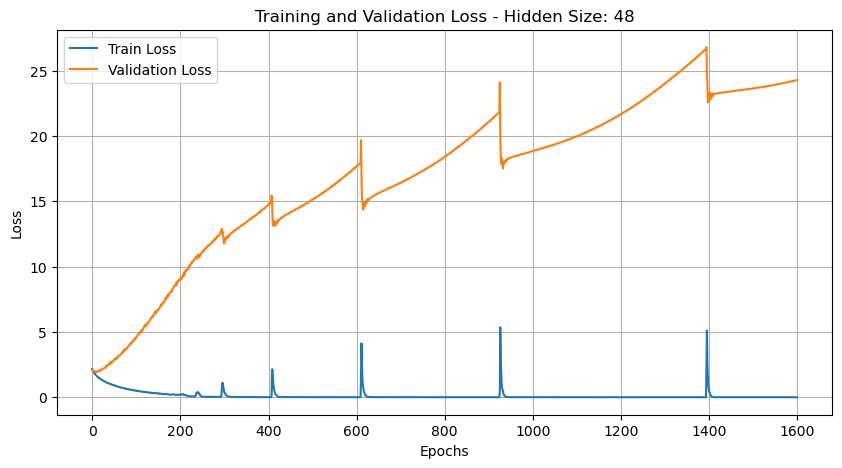


Entrenando modelo con 50 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00090 | Val Loss: 19.76225
Epoch: 1000/1600 | Train Loss: 0.00002 | Val Loss: 28.13526
Epoch: 1500/1600 | Train Loss: 0.00005 | Val Loss: 33.90229


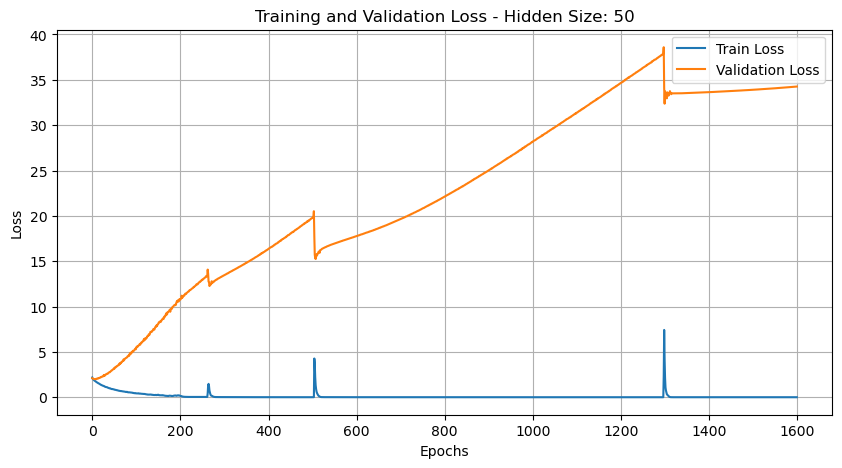


Entrenando modelo con 52 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00124 | Val Loss: 16.66353
Epoch: 1000/1600 | Train Loss: 0.00012 | Val Loss: 21.64842
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 35.46286


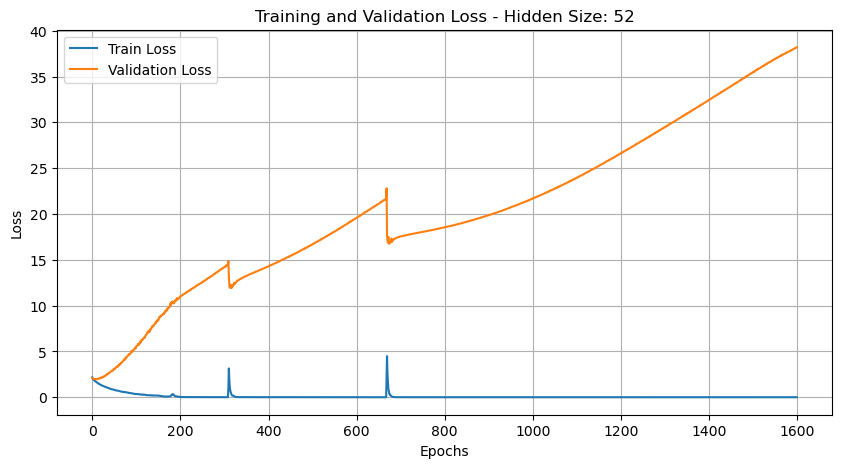


Entrenando modelo con 55 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00126 | Val Loss: 15.30600
Epoch: 1000/1600 | Train Loss: 0.00023 | Val Loss: 19.88095
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 29.79797


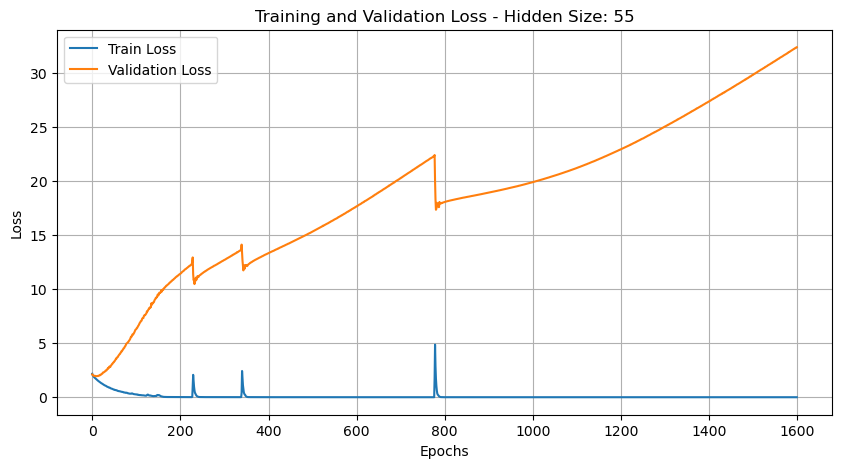


Entrenando modelo con 70 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00002 | Val Loss: 18.68047
Epoch: 1000/1600 | Train Loss: 0.01749 | Val Loss: 22.62032
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 25.01687


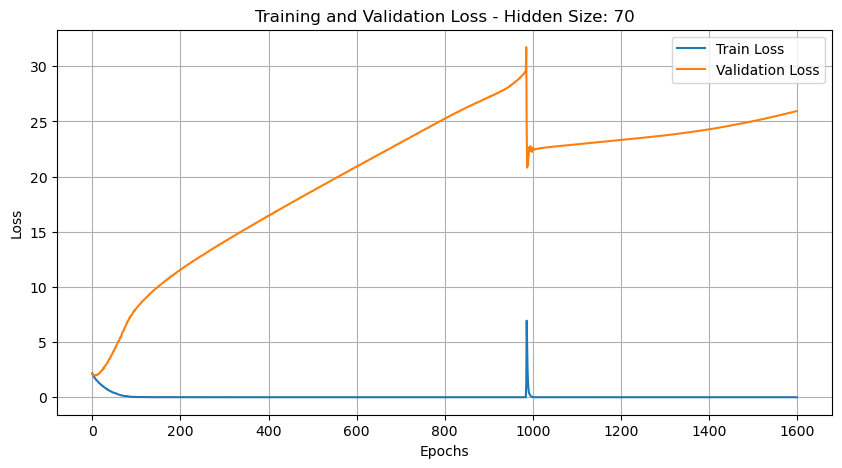


Entrenando modelo con 120 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00000 | Val Loss: 12.41239
Epoch: 1000/1600 | Train Loss: 0.00117 | Val Loss: 10.13357
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 16.47231


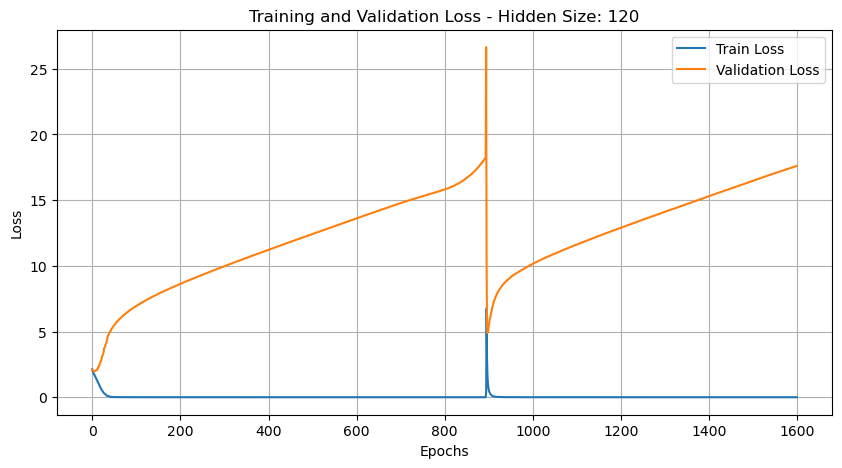


Entrenando modelo con 200 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00000 | Val Loss: 10.07486
Epoch: 1000/1600 | Train Loss: 0.00034 | Val Loss: 10.27101
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 15.83982


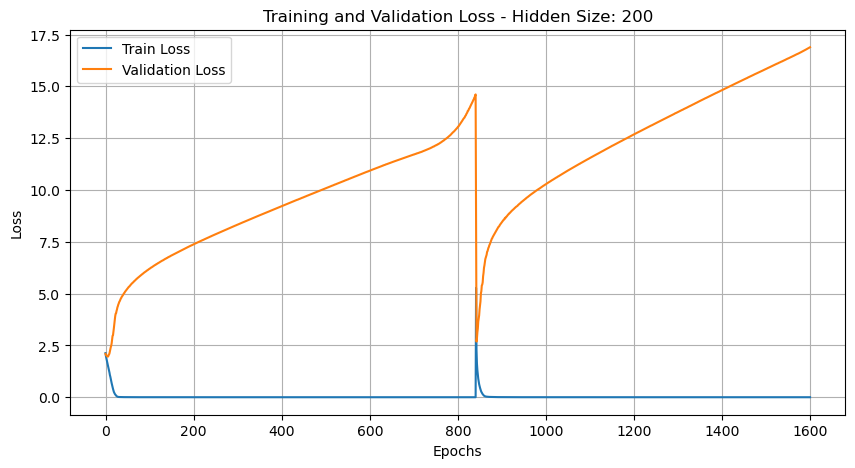


Entrenando modelo con 250 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00000 | Val Loss: 9.76779
Epoch: 1000/1600 | Train Loss: 0.00018 | Val Loss: 10.68984
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 16.31834


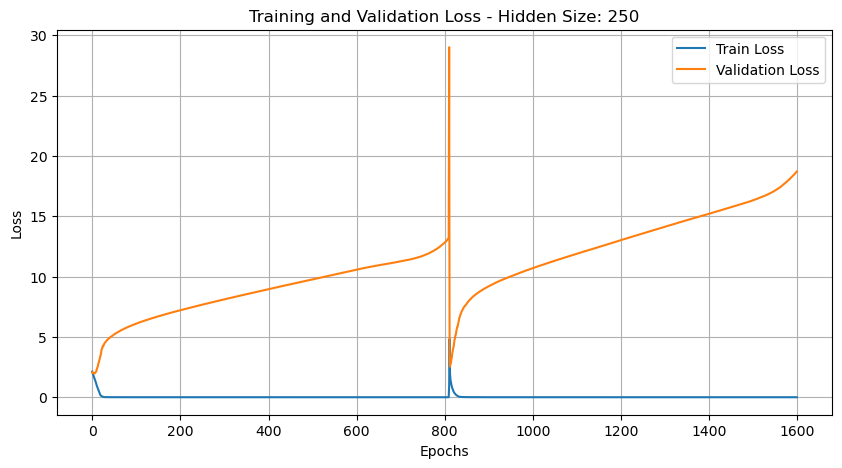


Entrenando modelo con 300 unidades ocultas
Epoch: 500/1600 | Train Loss: 0.00000 | Val Loss: 9.86110
Epoch: 1000/1600 | Train Loss: 0.00023 | Val Loss: 9.45384
Epoch: 1500/1600 | Train Loss: 0.00000 | Val Loss: 14.86412


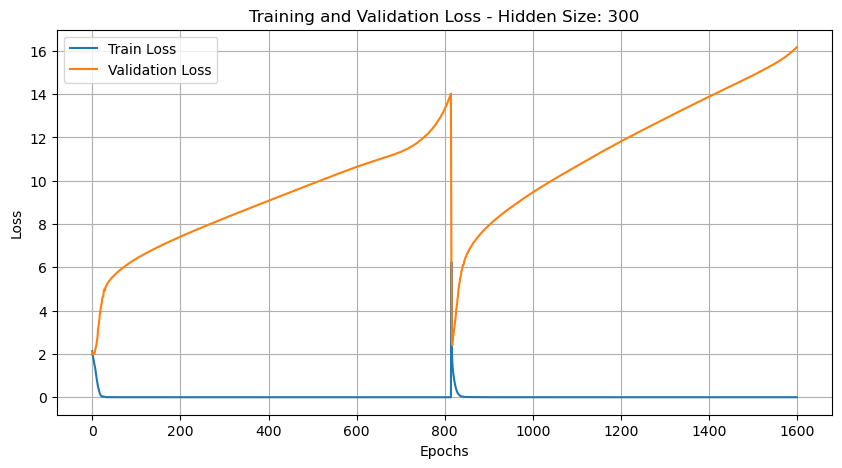

Entrenamiento finalizado. Errores finales:
Entrenamiento: [2.018734712600708, 1.4192520570755005, 0.9253361868858337, 0.0022921688901260495, 0.00022954370826482772, 2.131293455022387e-05, 4.563479947705673e-08, 1.6685571608832105e-07, 8.36326530588849e-07, 1.9397582263991352e-07, 5.040317077487089e-08, 2.838670845051183e-08, 3.192573345245364e-08]
Validación: [2.135925667626517, 2.977461269923619, 4.639236654554095, 20.885819298880442, 24.268157414027623, 34.25934655325754, 38.196296146937776, 32.37146323067801, 25.938346317836217, 17.60105405535017, 16.88901928492955, 18.71302468436105, 16.167149543762207]


In [ ]:
train_loader_noisy_30, val_loader_noisy_30 = get_dataloaders(data_noisy_30)
training_errors_noisy_30 = []
validation_errors_noisy_30 = []
param_counts_noisy_30 = []
for n_hidden in HIDDEN_SIZES:
    print(f"\nEntrenando modelo con {n_hidden} unidades ocultas")
    train_error, val_error, n_params = train_model(n_hidden, train_loader_noisy_30, val_loader_noisy_30)
    training_errors_noisy_30.append(train_error)
    validation_errors_noisy_30.append(val_error)
    param_counts_noisy_30.append(n_params)

# n_train es el tamaño REAL del split de entrenamiento (p.ej., 80% de 4000 = 3200)
n_train = len(train_loader_noisy_30.dataset)

print(f"Entrenamiento finalizado. Errores finales:")
print(f"Entrenamiento: {training_errors_noisy_30}")
print(f"Validación: {validation_errors_noisy_30}")

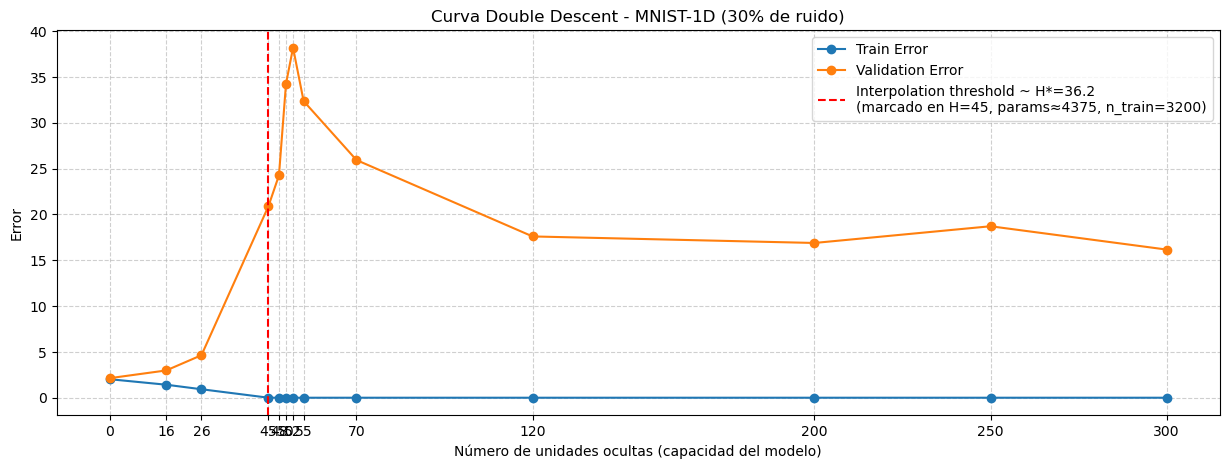

In [110]:
plot_double_descent(
    training_errors_noisy_30, validation_errors_noisy_30, 
    title="Curva Double Descent - MNIST-1D (30% de ruido)", n_train=n_train
)


## Preguntas finales

1. ¿Cómo afecta el **ruido en las etiquetas** al error mínimo de entrenamiento alcanzable? ¿Por qué ocurre esto?  
2. Según tus observaciones, ¿cómo influye el **ruido en las etiquetas** en el fenómeno de *Double Descent*, especialmente en relación con la **capacidad del modelo** y su **capacidad de generalización**?  
3. En *Deep Learning*, ¿es lo mismo el **overfitting** durante el entrenamiento que la **sobreparametrización** de los modelos? Explica las diferencias.


### 1. ¿Cómo afecta el ruido en las etiquetas al error mínimo de entrenamiento alcanzable?

En las tres curvas se ve que el error de entrenamiento siempre termina llegando a cero, incluso cuando hay ruido en las etiquetas.
Esto pasa porque los modelos con mucha capacidad son capaces de memorizar los datos del conjunto de entrenamiento, aunque parte de esas etiquetas sean incorrectas.

### 2.¿Cómo influye el ruido en las etiquetas en el fenómeno de Double Descent?

El ruido en las etiquetas cambia bastante la forma del Double Descent, de las pruebas realizadas podemos ver que cuanto mas ruido hay, mas cuesta ver el comportamiento del Double Descent. Sin ruido, la curva se ve como debería, el error de validación baja al principio, luego sube alrededor del punto donde el modelo empieza a memorizar los datos (Hidden = #params = 45) y después, cuando la red es mucho más grande, vuelve a bajar. Pero cuando agregamos ruido (10% y 30%), ese pico se vuelve mucho más alto, llegando a una loss de ~20 y ~40 respectivamente, ademas de ser más ancho, la bajada luego de este pico es mucho mas lenta estancandose al rededor de los ~8 y ~18. Esto pasa porque con ruido el modelo está intentando memorizar información que no es coherente, y eso hace que su capacidad de generalizar empeore, provocando en consecuencia un aumento del sobreajuste y evitando que los modelos grandes puedan “recuperarse” después del pico.

### 3. En Deep Learning, ¿es lo mismo el overfitting que la sobreparametrización?

No, no son lo mismo. El overfitting pasa cuando el modelo se ajusta tanto a los datos de entrenamiento que empieza a aprender también el ruido y los detalles específicos del dataset, perdiendo capacidad de generalizar, lo que hace que se obtengan buenos resultados en entrenamiento pero malos en validación o test.
La sobreparametrización se refiere a cuando el modelo tiene más parámetros que ejemplos de entrenamiento, o sea, mucha más capacidad de la necesaria para aprender la tarea.

Observando las pruebas realizadas podemos ver claramente el Double Descent, donde cerca del umbral de interpolacion ocurre el overfitting, pero a medida que el modelo se agranda, la loss en validacion tiende a bajar, lo que indica que los modelos vuelvan a generalizar gracias al segundo descenso del Double Descent. 